# OS Fingerprinting based on ML and p0f dataset

In [1]:
import numpy as np
import pandas as pd
import p0f_db_parser as parser

In [2]:
seed = 42
np.random.seed(seed)

### Parse database and import dataset

In [3]:
dataset,column_names = parser.parse_database("p0f.fp")
df = pd.DataFrame(dataset,columns=column_names)

### Explore dataset

In [4]:
print("Initial dataset")
df.head()

Initial dataset


,sig_direction,os,version,initial_ttl,mss,window_size,window_scaling,tcp_options,quirk_df,quirk_id,quirk_ts
0,request,Linux,3.11 and newer,64,*,mss*20,10,"mss,sok,ts,nop,ws",1,1,0
1,request,Linux,3.11 and newer,64,*,mss*20,7,"mss,sok,ts,nop,ws",1,1,0
2,request,Linux,3.1-3.10,64,*,mss*10,4,"mss,sok,ts,nop,ws",1,1,0
3,request,Linux,3.1-3.10,64,*,mss*10,5,"mss,sok,ts,nop,ws",1,1,0
4,request,Linux,3.1-3.10,64,*,mss*10,6,"mss,sok,ts,nop,ws",1,1,0


In [5]:
def DataCheckings(df):
    # Check the number of data points in the data set
    print("\nData points =", len(df))
    
    # Check the number of columns in the data set
    print("\nColumns (output + features)=",len(df.columns))
    
    # Check the data types
    print("\nData types =", df.dtypes.unique())

    # Check the number of duplicates
    print("Number of duplicates: ", df.duplicated().sum())

    # Dataset statistics
    print('\n')
    df.describe()
    
    # print names of columns
    print('Column Names:\n', df.columns)
    
    # see if there are categorical data
    print("\nCategorical features:", df.select_dtypes(include=['O']).columns.tolist())
    
    # Check NA values
    # Check any number of columns with NaN
    print("\nColumns with NaN: ", df.isnull().any().sum(), ' / ', len(df.columns))

    # Check any number of data points with NaN
    print("\nNumber of data points with NaN:", df.isnull().any(axis=1).sum(), ' / ', len(df))
    
    # List of values per column
    print()
    for column in df.columns:
        print(column + " -> ")
        print(df[column].value_counts())
        print()

In [6]:
DataCheckings(df)


Data points = 180

Columns (output + features)= 11

Data types = [dtype('O') dtype('int64')]
Number of duplicates:  0


Column Names:
 Index(['sig_direction', 'os', 'version', 'initial_ttl', 'mss', 'window_size',
       'window_scaling', 'tcp_options', 'quirk_df', 'quirk_id', 'quirk_ts'],
      dtype='object')

Categorical features: ['sig_direction', 'os', 'version', 'mss', 'window_size', 'window_scaling', 'tcp_options']

Columns with NaN:  0  /  11

Number of data points with NaN: 0  /  180

sig_direction -> 
response    101
request      79
Name: sig_direction, dtype: int64

os -> 
Linux          51
Windows        43
Solaris        22
FreeBSD        14
Mac OS X       11
OpenBSD         9
p0f             8
HP-UX           8
OpenVMS         4
Tru64           3
Nintendo        2
BaiduSpider     2
iOS             1
NeXTSTEP        1
Blackberry      1
Name: os, dtype: int64

version -> 
XP                                          21
7 or 8                                      12
3.x      

In [7]:
# Checking duplicates

print("Number of duplicates: ", df.duplicated().sum())

Number of duplicates:  0


### Encoding of the dataset

In [1]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
import ai_model_creation.ai_p0f_model_creation.transformers as tr

ModuleNotFoundError: No module named 'ai_model_creation'

#### Filter Operating Systems

In [9]:
# Filter OSes
df = df[df.os.isin(['Linux', 'Windows', 'Mac OS X', 'Solaris', 'OpenBSD', 'FreeBSD'])]
df.replace({'os': {'FreeBSD': 'BSD', 'OpenBSD': 'BSD'}}, inplace=True)

df.reset_index(inplace=True, drop=True)

# Drop version column
df.drop(["version","sig_direction"], inplace=True, axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   os              150 non-null    object
 1   initial_ttl     150 non-null    int64 
 2   mss             150 non-null    object
 3   window_size     150 non-null    object
 4   window_scaling  150 non-null    object
 5   tcp_options     150 non-null    object
 6   quirk_df        150 non-null    int64 
 7   quirk_id        150 non-null    int64 
 8   quirk_ts        150 non-null    int64 
dtypes: int64(4), object(5)
memory usage: 10.7+ KB


#### Data Augmentation

In [11]:
# Data Augmentation
# TTL, MSS & Windows size

ttl_factor = 10

array = df.to_numpy()
ttl_i = df.columns.get_loc('initial_ttl')

for row in array:
    for i in range(1,ttl_factor+1):
        new_row = row.copy()
        new_row[ttl_i] = row[ttl_i] - i
        
        array = np.vstack((array, new_row))
        
df = pd.DataFrame(array, columns = df.columns)

#### TTL

In [12]:
# TTL
# Numeric value

encoder_ttl = MinMaxScaler()

#### MSS

In [13]:
# MSS
# Categorical encoding

# encoder_mss = OneHotEncoder(drop=['*'], sparse=False, handle_unknown='ignore')
df.drop('mss', inplace=True, axis=1)

#### Window Size

In [14]:
# Window Size

# encoder_window_size = tr.WindowSizeTransformer()
df.drop('window_size', inplace=True, axis=1)

#### Windows Scaling

In [15]:
# Window Scaling 
# Categorical encoding

encoder_window_scaling = OneHotEncoder(drop=['*'], sparse_output=False, handle_unknown='ignore')

#### TCP options

In [16]:
# TCP Options
# Custom transformer

encoder_tcp_options = tr.TCPOptionsTransformer()


#### Quirks

In [17]:
# Quirks
# Categorical encoding (already encoded)

#### Applying encodings

In [18]:
# Apply encodings

from sklearn.compose import make_column_transformer

df.reset_index(inplace=True, drop=True)

encoders = make_column_transformer(
    (encoder_ttl, ['initial_ttl']),
    (encoder_window_scaling, ['window_scaling']),
    (encoder_tcp_options, ['tcp_options']),
    remainder='passthrough',
    verbose_feature_names_out=False)

transformed = encoders.fit_transform(df)
transformed_df = pd.DataFrame(
    transformed,
    columns=encoders.get_feature_names_out()
)

df = transformed_df

# define output variable name
OutVar = df.os.name

In [19]:
df.head()

,initial_ttl,window_scaling_0,window_scaling_1,window_scaling_10,window_scaling_2,window_scaling_3,window_scaling_4,window_scaling_5,window_scaling_6,window_scaling_7,...,tcp_options8_mss,tcp_options8_sok,tcp_options8_ts,tcp_options8_nop,tcp_options8_ws,tcp_options8_eol+1,os,quirk_df,quirk_id,quirk_ts
0,0.049751,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Linux,1,1,0
1,0.049751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Linux,1,1,0
2,0.049751,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Linux,1,1,0
3,0.049751,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Linux,1,1,0
4,0.049751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Linux,1,1,0


In [20]:
DataCheckings(df)


Data points = 1650

Columns (output + features)= 69

Data types = [dtype('O')]
Number of duplicates:  605


Column Names:
 Index(['initial_ttl', 'window_scaling_0', 'window_scaling_1',
       'window_scaling_10', 'window_scaling_2', 'window_scaling_3',
       'window_scaling_4', 'window_scaling_5', 'window_scaling_6',
       'window_scaling_7', 'window_scaling_8', 'tcp_options0_mss',
       'tcp_options0_sok', 'tcp_options0_ts', 'tcp_options0_nop',
       'tcp_options0_ws', 'tcp_options0_eol+1', 'tcp_options1_mss',
       'tcp_options1_sok', 'tcp_options1_ts', 'tcp_options1_nop',
       'tcp_options1_ws', 'tcp_options1_eol+1', 'tcp_options2_mss',
       'tcp_options2_sok', 'tcp_options2_ts', 'tcp_options2_nop',
       'tcp_options2_ws', 'tcp_options2_eol+1', 'tcp_options3_mss',
       'tcp_options3_sok', 'tcp_options3_ts', 'tcp_options3_nop',
       'tcp_options3_ws', 'tcp_options3_eol+1', 'tcp_options4_mss',
       'tcp_options4_sok', 'tcp_options4_ts', 'tcp_options4_nop',
       'tc

In [21]:
df = df.drop_duplicates()

#### Dataset split

In [22]:
# Create two datasets: requests and responses

# df = df[df.sig_direction.isin(['request'])].drop('sig_direction', axis=1)
# df_response = df[df.sig_direction.isin(['response'])].drop('sig_direction', axis=1)

# df.reset_index(inplace=True, drop=True)
# df_response.reset_index(inplace=True, drop=True)

# del df

### Verify the classes ballance

In [23]:
df[OutVar].value_counts()

Linux       297
Windows     231
Solaris     209
BSD         187
Mac OS X    121
Name: os, dtype: int64

### Get data as arrays

In [24]:
# Request

Ydata = df[OutVar].values                  # get values of features
Xdata = df.drop(OutVar,axis = 1).values    # get output values

print('Shape X data:', Xdata.shape)
print('Shape Y data:',Ydata.shape)

Shape X data: (1045, 68)
Shape Y data: (1045,)


### Data split

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
# # Request

X_train, X_test, Y_train, Y_test = train_test_split(Xdata, Ydata, stratify=Ydata, test_size=0.20, random_state=seed)

# # verify dimentions of data for training and test
# print('Shape X_train:', X_train.shape)
# print('Shape X_test:' , X_test.shape)
# print('Shape y_train:', y_train.shape)
# print('Shape y_test:' , y_test.shape)

### ML

In [27]:
import time
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score, roc_auc_score,f1_score, recall_score, precision_score
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

##### Classes balance

In [28]:
def set_weights(y_data, option='balanced'):
    """Estimate class weights for umbalanced dataset
       If ‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y)). 
       If a dictionary is given, keys are classes and values are corresponding class weights. 
       If None is given, the class weights will be uniform """
    cw = class_weight.compute_class_weight(class_weight=option, classes=np.unique(y_data), y=y_data)
    w = {i:j for i,j in zip(np.unique(y_data), cw)}
    return w

class_weights = set_weights(Ydata)

print("Request balance => ",class_weights)

Request balance =>  {'BSD': 1.1176470588235294, 'Linux': 0.7037037037037037, 'Mac OS X': 1.7272727272727273, 'Solaris': 1.0, 'Windows': 0.9047619047619048}


##### Classifiers definition

In [29]:
# define a list of classifiers to train as baseline classifiers
# classifiers = [
#     GaussianNB(),
#     LinearDiscriminantAnalysis(), # No random_state
#     LogisticRegression(n_jobs=-1,solver='lbfgs',random_state=seed,class_weight=class_weights),
#     MLPClassifier(hidden_layer_sizes= (30), random_state = seed, shuffle=False, solver='adam',activation='relu',batch_size=500, max_iter=5000),
#     DecisionTreeClassifier(random_state=seed,class_weight=class_weights),
#     RandomForestClassifier(n_jobs=-1,random_state=seed,class_weight=class_weights),
#     BaggingClassifier(n_jobs=-1,random_state=seed)
# ]

classifiers = [
    GaussianNB(),
    BernoulliNB(),
    LinearDiscriminantAnalysis(),
    KNeighborsClassifier(),
    LogisticRegression(n_jobs=-1,solver='lbfgs',multi_class='multinomial' , random_state=seed,class_weight=class_weights),
    MLPClassifier(hidden_layer_sizes= (30), random_state = seed, shuffle=False, solver='adam',activation='relu',batch_size=30, max_iter=5000),
    DecisionTreeClassifier(random_state=seed,class_weight=class_weights),
    RandomForestClassifier(n_jobs=-1,random_state=seed,class_weight=class_weights),
]

##### Training

In [30]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, LeaveOneOut
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import make_scorer

In [31]:
scores = []

# Scoring
# scoring = 'accuracy'
scoring = make_scorer(cohen_kappa_score)

# Cross-validation method
# cv = LeaveOneOut()
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=60,random_state=seed)
# cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)

for classifier in classifiers:
    results = cross_val_score(classifier,X_train,Y_train,cv=cv,scoring=scoring)
    scores.append([str(type(classifier).__name__), results.mean()])


# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.plot(hiper_k_rango,scores)
# plt.xlabel("Valores de k")
# plt.ylabel("Accuracy en 50 repeticiones 10-fold cross-validation")

In [32]:
from operator import itemgetter

sorted(scores, key=itemgetter(1))

[['BernoulliNB', 0.6910373815708898],
 ['GaussianNB', 0.8036256845661983],
 ['LinearDiscriminantAnalysis', 0.8139800939040437],
 ['LogisticRegression', 0.8789167109379306],
 ['DecisionTreeClassifier', 0.8857604986707285],
 ['RandomForestClassifier', 0.8875123226595597],
 ['KNeighborsClassifier', 0.9039596224751721],
 ['MLPClassifier', 0.921149764921952]]

#### Hyperparameter tunning

In [34]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Decision Tree
# classifier = DecisionTreeClassifier(random_state=seed,class_weight=class_weights)
# grid_parameters =[
#     {'max_depth':[None, 5, 10, 100, 500, 1000], 'min_samples_split':[2,4,6,8]}
# ]

# MLP CLassifier
classifier = MLPClassifier(random_state = seed, shuffle=False, solver='adam',activation='relu',batch_size=30, max_iter=100)
grid_parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
    

grid_search = GridSearchCV(
    classifier, 
    grid_parameters, 
    cv=cv,
    scoring=scoring,
    return_train_score=False,
    verbose=3,
    n_jobs=-1,
    refit=True,
)

grid_search.fit(X_train,Y_train)

grid_search.best_params_

Fitting 300 folds for each of 48 candidates, totalling 14400 fits


c:\Users\ruben\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu',
 'alpha': 0.05,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'solver': 'adam'}

#### Final validation

In [35]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

In [36]:
y_true, y_pred = Y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         BSD       0.91      0.84      0.88        38
       Linux       1.00      0.97      0.98        59
    Mac OS X       0.79      0.92      0.85        24
     Solaris       0.88      0.90      0.89        42
     Windows       1.00      1.00      1.00        46

    accuracy                           0.93       209
   macro avg       0.92      0.93      0.92       209
weighted avg       0.94      0.93      0.93       209



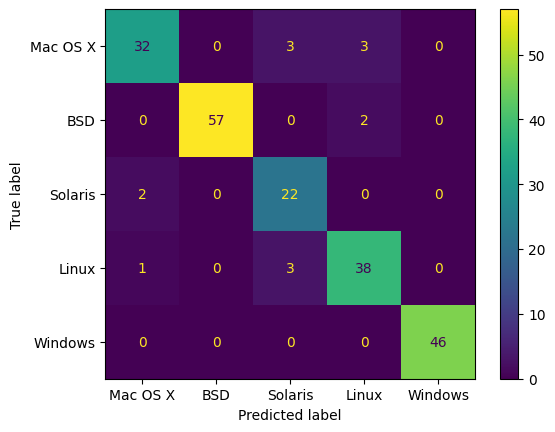

In [51]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred, labels=grid_search.classes_),display_labels=['Mac OS X', 'BSD', 'Solaris', 'Linux', 'Windows'])

disp.plot()

In [41]:
import matplotlib.pyplot as plt

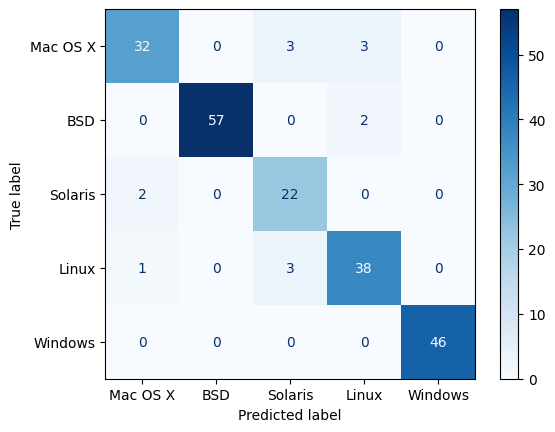

In [52]:
disp.plot(cmap=plt.cm.Blues)

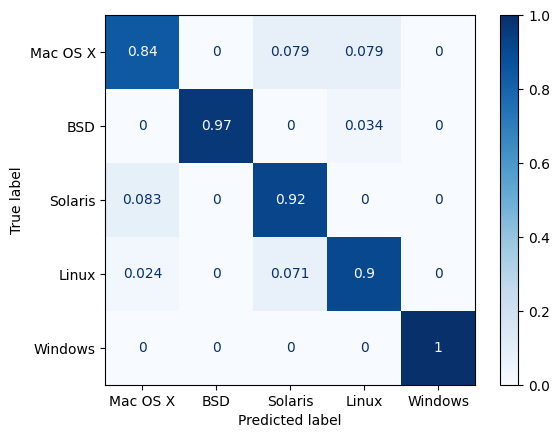

In [53]:
disp2 = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred, labels=grid_search.classes_,normalize='true'),display_labels=['Mac OS X', 'BSD','Solaris', 'Linux', 'Windows'])
disp2.plot(cmap=plt.cm.Blues)

In [43]:
print(cohen_kappa_score(y_true, y_pred))

0.9149270221550271


### Export transformers & model

In [54]:
from joblib import dump

# Transformers
dump(encoders, '../../persistence/p0f/p0f_encoders.joblib')

# Models
dump(grid_search.best_estimator_,'../../persistence/p0f/p0f_classifier.joblib')

['../../persistence/p0f/p0f_classifier.joblib']